# Algorithms underlying directional hearing in _Danionella c._ startle behavior

This notebook produces the plots from Figure 3 & 4.  

## Imports and helper functions

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import pandas as pd
import scipy
from mpl_toolkits.axes_grid1 import make_axes_locatable
import seaborn as sns
from scipy.signal import hilbert
from scipy.optimize import curve_fit

In [6]:
def ax_format(ax):
    ax.set_xlim([-2.1, 2.1])
    ax.set_ylim([-2.1, 2.1])
    ax.set_xticks([])
    ax.set_yticks([])
    ax.spines[['right', 'top', 'left', 'bottom']].set_visible(False)
    ax.set_aspect('equal')


def ax_ctr_trajectories(df, groupby, group, start, stop, ax, plt_hist=True, Bonf_corr=0):
    """
    Plots centered displacement trajectories to a matplotlib axis based on the provided DataFrame.

    Parameters:
    df (DataFrame): The DataFrame containing the fish data.
    groupby (str): The column name to group the DataFrame by.
    group (str): The specific group to select from the DataFrame.
    start (int): The start index for slicing the DataFrame. Before startle initiation.
    stop (int): The stop index for slicing the DataFrame. End of initial startle phase.
    ax (matplotlib axis): Matplotlib axis for plotting
    plt_hist (bool, optional): If True, plots a histogram below the trajectories. Defaults to True.
    Bonf_corr (int, optional): Number of comparisons for Bonferroni correction. If 0, no correction.
    """
    # grouping
    tmp = df[(df[groupby] == group)]
    nfish = len(tmp['fish_id'].unique())

    # displacements
    xtmp = np.stack(tmp['s7_x_cm'].values).T[:, tmp['startle']]
    hist_color = "Blues"

    ytmp = np.stack(tmp['s7_y_cm'].values).T[:, tmp['startle']]
    xtmp = np.squeeze(xtmp[start:stop + 1])
    ytmp = np.squeeze(ytmp[start:stop + 1])
    xtmp -= xtmp[0]
    ytmp -= ytmp[0]

    idxright = xtmp[-1] > xtmp[0]
    toright = np.sum(idxright)
    idxleft = xtmp[-1] <= xtmp[0]
    toleft = np.sum(idxleft)

    # plot histogram
    if plt_hist:
        hist, _, _, _ = ax.hist2d(xtmp[-1, idxright + idxleft], ytmp[-1, idxright + idxleft], bins=8,
                                  range=[[-1.5, 1.5], [-1.5, 1.5]], cmap=hist_color)
        interpolate = 1
        if interpolate:
            ax.clear()
            ax.imshow(hist.T, origin="lower", interpolation="gaussian", extent=[-1.5, 1.5, -1.5, 1.5], cmap=hist_color,
                      alpha=.7)
        ax.set_aspect('equal')

    # plot trajectories
    ax.plot(xtmp[:, idxright + idxleft], ytmp[:, idxright + idxleft], '-', lw=1, color='k', alpha=0.2, zorder=3)

    # plot origin
    ax.axvline(0, -1.5, 1.5, ls='--', lw=1.5, color='black', alpha=.3, zorder=9)
    ax.scatter(0, 0, marker='o', s=80, color='white', alpha=1, zorder=10)
    ax.spines[['right', 'top', 'left', 'bottom']].set_visible(False)

    # statistics
    frac_toright = toright / (toright + toleft)
    p = scipy.stats.binomtest(toright, toright + toleft, 0.5, alternative='two-sided').pvalue
    Bonf_flag = ""
    if Bonf_corr != 0:
        p *= Bonf_corr
        Bonf_flag = f"\nBonf. corrected: n={Bonf_corr}"

    ax.set_xlim([-1.5, 1.5])
    ax.set_ylim([-1.5, 1.5])
    ax.set_aspect('equal')
    ax.set_title(f'{group}\n {(frac_toright * 100):.1f}% of {toright + toleft},\np = {p:.1g}, {nfish} fish{Bonf_flag}')


def plot_trajectories(df, groupby, groups, f1, f2, frate=None):
    """
    Wrapper to plot centered displacement trajectories.

    Parameters:
    df (DataFrame): The DataFrame containing the fish data.
    groupby (str): The column name to group the DataFrame by.
    groups (str): Groups allow for user defined order.
    f1 (int): The start index for slicing the DataFrame. Before startle initiation.
    f2 (int): The stop index for slicing the DataFrame. End of initial startle phase.
    frate (float): Framerate of the trajectory data

    Returns: fig, ax
    """
    n = len(groups)
    fig, axs = plt.subplots(nrows=1, ncols=n, figsize=(6 * n, 10))
    for i, group in enumerate(groups):
        if n == 1:
            ax = axs
        else:
            ax = axs[i]
        ax_ctr_trajectories(df, groupby, group, f1, f2, ax=ax, plt_hist=True)
        ax.set_xticks([])
        if i != 0:
            ax.set_yticks([])
        else:
            ax.set_ylabel("y [cm]")

    fig.tight_layout()
    fig.subplots_adjust(top=1.15)
    return fig, axs


def myboxplot(df, x, y, hue, figsize=(12, 12), rotate=True, order=None):
    PROPS = {
        'boxprops': {'facecolor': 'none', 'edgecolor': 'black'},
        'medianprops': {'color': 'black'},
        'whiskerprops': {'color': 'black'},
        'capprops': {'color': 'black'}
    }
    ax = sns.catplot(x=x, y=y, data=df, kind='box', order=order, **PROPS)
    if rotate:
        ax.set_xticklabels(rotation=90)
    ax = sns.stripplot(x=x, y=y, hue=hue, data=df, alpha=0.7, size=5, jitter=0.03, palette='dark:k', order=order)
    ax.legend_.remove()
    fig = plt.gcf()
    fig.set_size_inches(figsize)
    fig.tight_layout()
    return fig, ax


def plot_individual_dirbias(df, groupby):
    """
    Plot directional bias for individual fish. Makes sure that only fish are selected that had at least 1 startle in each compared stimulus category.

    Parameters:
    df (DataFrame): The DataFrame containing the fish data.
    groupby (str): The column name to group the DataFrame by.

    Returns: fig, ax
    """
    fltrflag = f"each_{groupby}_startled1"
    isnan = np.isnan(df['toright'].values)
    startles_ap_phases = pd.crosstab(df[~isnan][groupby], df[~isnan]['fish_id'])
    each_apphase = pd.DataFrame(~((startles_ap_phases < 1).any()), columns=[fltrflag]).reset_index()
    df_filt = pd.merge(df, each_apphase, on='fish_id')
    df_filt = df_filt[df_filt[fltrflag]]

    # averages
    tmp_mean = df[~isnan].groupby([groupby])['toright'].agg(['mean', 'sum', 'std'])
    tmp_mean.reset_index(inplace=True)
    tmp_mean['mean'] -= .5
    tmp_mean[groupby] = tmp_mean[groupby].astype(str)

    # per individual
    isnan = np.isnan(df_filt['toright'].values)
    tmp_mean_by_expt = df_filt[~isnan].groupby([groupby, 'fish_id'])['toright'].agg(['mean', 'sum', 'std'])
    tmp_mean_by_expt.reset_index(inplace=True)
    tmp_mean_by_expt['mean'] -= .5
    tmp_mean_by_expt[groupby] = tmp_mean_by_expt[groupby].astype(str)

    fig, ax = myboxplot(tmp_mean_by_expt, groupby, 'mean', 'fish_id', figsize=(6, 5))

    sns.stripplot(x=groupby, y='mean', data=tmp_mean, alpha=.5, size=12, jitter=0, color=".3", marker="D",
                  legend=False)  # unfiltered data
    sns.lineplot(x=groupby, y='mean', data=tmp_mean, color=".3", ls='--', legend=False)  # unfiltered data
    plt.axhline(0, c='k')
    ax.set_title(f"Individual directional bias\n ≥ 1 startles/fish")
    plt.xlabel(groupby),plt.ylabel('Directional Bias')
    plt.ylim([-.6, .6])
    fig.tight_layout()
    return fig, ax


def plot_tc_by_freq(df, annotate_ps=True):
    """
    Plots the tuning curves for directional bias in startle response by frequency

    Parameters:
    df (DataFrame): The DataFrame containing the experimental data.
    annotate_ps (bool): Whether to annotate the p-values for binomial tests on the plot

    Returns: fig,ax
    """
    fig, ax = plt.subplots(figsize=(6, 5))

    # bins
    bin_centers = sorted(np.unique(df['ap-phase'].values) % 2)
    bin_width = np.diff(bin_centers)[0]
    edg = bin_centers - bin_width / 2
    edg = np.hstack((edg, edg[-1] + bin_width))

    markers = ['o', 's', 'D', '*', 'd']
    freqs = sorted(df['frequency'].unique())
    for i, f in enumerate(freqs):
        df_tmp = df[df['frequency'] == f]
        isnan = np.isnan(df_tmp['toright'].values)

        # stats
        bin_means, xbin_edges, binnumber = scipy.stats.binned_statistic(x=df_tmp['ap-phase'].values[~isnan] % 2,
                                                                        values=df_tmp['toright'].values[~isnan],
                                                                        bins=edg, statistic='mean')
        bin_counts, _, _ = scipy.stats.binned_statistic(x=df_tmp['ap-phase'].values[~isnan] % 2,
                                                        values=df_tmp['toright'].values[~isnan], bins=edg,
                                                        statistic='count')
        bin_sums, _, _ = scipy.stats.binned_statistic(x=df_tmp['ap-phase'].values[~isnan] % 2,
                                                      values=df_tmp['toright'].values[~isnan], bins=edg,
                                                      statistic='sum')
        p_vals = [scipy.stats.binomtest(int(summed), int(cnt), 0.5, alternative='two-sided').pvalue for summed, cnt in
                  zip(bin_sums, bin_counts)]

        if 400 == f:
            c = (122 / 255, 129 / 255, 255 / 255)
        elif 800 == f:
            c = (118 / 255, 214 / 255, 255 / 255)
        elif 1200 == f:
            c = (115 / 255, 252 / 255, 214 / 255)
        elif 2000 == f:
            c = (115 / 255, 250 / 255, 121 / 255)
        elif 5000 == f:
            c = (255 / 255, 212 / 255, 121 / 255)
        else:
            c = 'k'

        # plot
        x = xbin_edges[:-1] + bin_width / 2
        x = np.concatenate((x, x[0:4] + 2))
        mean = bin_means - 0.5
        mean = np.concatenate((mean, mean[0:4]))
        ax.plot(x, mean, lw=2.2, ms=6, marker=markers[i], c=c, label=f"f = {f} Hz")

        # annotation
        if annotate_ps:
            for j, (p, cnt) in enumerate(zip(p_vals, bin_counts)):
                ax.annotate(f"{p:.1g} ({int(cnt)})", (x[j] - 0.07, mean[j] - 0.02), c=c, fontsize=8, alpha=1)
                ax.annotate(f"{p:.1g} ({int(cnt)})", (x[j] - 0.07, mean[j] - 0.02), fontsize=8, alpha=.4)

    ax.set_ylim([-.4, .4]), ax.axhline(0, color='k', ls='--'), ax.xaxis.set_major_locator(
        ticker.MultipleLocator(base=.5))
    ax.set_xlabel(r"$\phi_{ap} [\pi]$"), ax.set_ylabel("Directional Bias")
    ax.spines['top'].set_visible(False), ax.spines['right'].set_visible(False)
    ax.legend(fontsize=8, loc="lower left")
    fig.tight_layout()
    return fig, ax


def tc_fit(df):
    """
    Performs fit of model paramters to directional tuning curve.

    Parameters:
    df (DataFrame): The DataFrame containing the experimental data.

    Returns: fig,ax
    """

    freqs = sorted(df['frequency'].unique())
    data_f = np.array([])
    data_phases = np.array([])

    # bins
    bin_centers = sorted(np.unique(df['ap-phase'].values) % 2)
    bin_width = np.diff(bin_centers)[0]  # same widths
    edg = bin_centers - bin_width / 2
    edg = np.hstack((edg, edg[-1] + bin_width))

    for f in freqs:
        if f < 3000:
            df_filt = df[df['frequency'] == f]
            isnan = np.isnan(df_filt['toright'].values)
            bin_means, xbin_edges, binnumber = scipy.stats.binned_statistic(x=df_filt['ap-phase'].values[~isnan] % 2,
                                                                            values=df_filt['toright'].values[~isnan],
                                                                            bins=edg, statistic='mean')
            bin_counts, _, _ = scipy.stats.binned_statistic(x=df_filt['ap-phase'].values[~isnan] % 2,
                                                            values=df_filt['toright'].values[~isnan], bins=edg,
                                                            statistic='count')
            bin_sums, _, _ = scipy.stats.binned_statistic(x=df_filt['ap-phase'].values[~isnan] % 2,
                                                          values=df_filt['toright'].values[~isnan], bins=edg,
                                                          statistic='sum')

            ap = np.pi * (xbin_edges[:-1] + bin_width / 2)  # cast back to true phase in radians
            curve = bin_means
            curve -= 0.5  # cast probability of rightward startle to directional bias score

            # remove mean directional bias (bias in bias)
            # curve = curve-curve.real.mean()

            phases = (np.angle(hilbert(curve)) - ap) % (2 * np.pi)

            f_r = f * np.ones(len(phases))
            data_f = np.hstack((data_f, f_r))
            data_phases = np.hstack((data_phases, phases))

    # shift phases
    data_phases = (data_phases - np.pi) % (2 * np.pi) + np.pi - 2 * np.pi

    # Fit Model
    def linear_model(x, m, b):
        return m * x + b

    params, covariance = curve_fit(linear_model, data_f[data_f < 1300], data_phases[data_f < 1300])
    m_fit, b_fit = params
    m_std = np.sqrt(covariance[0, 0])
    b_std = np.sqrt(covariance[1, 1])
    print(f"Fit: {float(m_fit) / (2 * np.pi):.7g}*2π*f + {float(b_fit) / np.pi:.7g}π")

    # Plot fit
    plt.figure(figsize=(6, 6))
    plt.scatter(data_f, data_phases / np.pi, s=10)
    f_plot = np.hstack((np.array([0]), np.sort(np.unique(data_f))))
    plt.plot(f_plot, (m_fit * f_plot + b_fit) / np.pi, c="k",
             label=f"Fit: {float(m_fit) / (2 * np.pi):.3g}*2π*f + {float(b_fit) / np.pi:.3g}π")
    plt.axvline(abs(1 / (2 * m_fit / (2 * np.pi))), ls="--", c=".4", label=f"Phase breakdown: m = T/2 -> f = abs(1/2m)")
    plt.axhline(b_fit / np.pi - 1, ls="--", c=".4", label=f"b - π")
    plt.legend(fontsize=10)
    plt.title(
        f"Fit: y = 2*π*mx + b, \nm = {m_fit / (2 * np.pi):.3g} +/- {m_std / (2 * np.pi):.3g}, \nb = {b_fit:.3g} +/- {b_std:.3g} = {b_fit / np.pi:.3g}π +/- {b_std / np.pi:.3g}π",
        fontsize=10)
    plt.xlabel("Frequency [Hz]"), plt.ylabel(r"$\phi_{fish} [\pi]$")
    plt.xlim([0, 2500]), plt.ylim([-1.1, 1.1])
    plt.gca().spines['top'].set_visible(False), plt.gca().spines['right'].set_visible(False)
    plt.tight_layout()
    return plt.gcf(), plt.gca()

In [7]:
# PARAMETERS
# Camera
cmppx = 0.03289473684210526 # centimeters per pixel
w = 336 # video width
h = 336 # video height
frate = 120 # video framerate

# Startle detection
v_thr = 17 # threshold for temporal mean speed
thr_f0 = 604 # start of temporal window
thr_f1 = 607 # end of temporal window

# Timing
f0 = 600 # data is centered on this playback trigger frame
f1 = 602 # frame before startle initialization
f2 = 608 # frame when initial startle phase ends

# Node names for SLEAP tracking
slp_node_names = ['s1', 's2', 's3', 's4', 's5', 's6', 's7', 'left_eye', 'right_eye']

## Figures 3B-D
Plots based on experiment 1.

### Data

In [8]:
#!wget https://gin.g-node.org/danionella/Veith_et_al_2024/raw/6befcd4b4c0cd7434b6b2fa9595dd80599451366/behavior/74fish_lla.zip -O 2Dphases.zip
fn = "../../preprocessed_data_gnode_upload/2Dphases.zip"
df1 = pd.read_pickle(fn)

#### The dataframe object
Playbacks were triggered in the trigger zone at the tank's center. Each row of the dataframe contains one playack event.
Fish trajectories are centered on the playback video frame and contain 5s before and 7s after playback trigger.  

#### Coordinate columns
`slp_x` and `slp_y`

contain coordinates for all nine SLEAP nodes:
```
['s1', 's2', 's3', 's4', 's5', 's6', 's7', 'left_eye', 'right_eye']  

s1 to s4 - tail  
s5 - caudal swimbladder  
s6 - rostral swimbladder
s7 - head   
```
  
`s7_x_cm`, `s7_y_cm` and `s7_v_cmps`
contain interpolated trajectories for the head node `s7`, filtered for successful tracking and converted into centimeters or centimeters per second (cmps).

### Startle classification

Startles are detected via a speed threshold after playback.
To pool over startle trajectories after playback from a left speaker and playback from a right speaker, trajectories following right speaker playback were mirrored in a new column name `s7_x_cm_away`. Positive displacement is then a displacement directed away from the speaker.  
We pool data over different stimulus configurations below.

In [9]:
# Core analysis & grouping over stimuli
x = np.stack(df1["s7_x_cm"].values)
y = np.stack(df1["s7_y_cm"].values)
v = np.stack(df1["s7_v_cmps"].values)
t = (np.arange(x.shape[1]) - f0)/frate
tv = t[:-1] + 0.5 / frate

startle = np.nanmean(abs(v[:,thr_f0:thr_f1]),axis=1) > v_thr
df1['startle'] = startle
print(f"{np.sum(startle)} startle(s) detected.")

1240 startle(s) detected.


/tmp/ipykernel_1822121/1324814887.py:8: RuntimeWarning: Mean of empty slice
  startle = np.nanmean(abs(v[:,thr_f0:thr_f1]),axis=1) > v_thr


(None,
 Text(0.5, 1.0, 'Fish Speed around playback events\n'),
 <matplotlib.legend.Legend at 0x7f0b9d1678c0>)

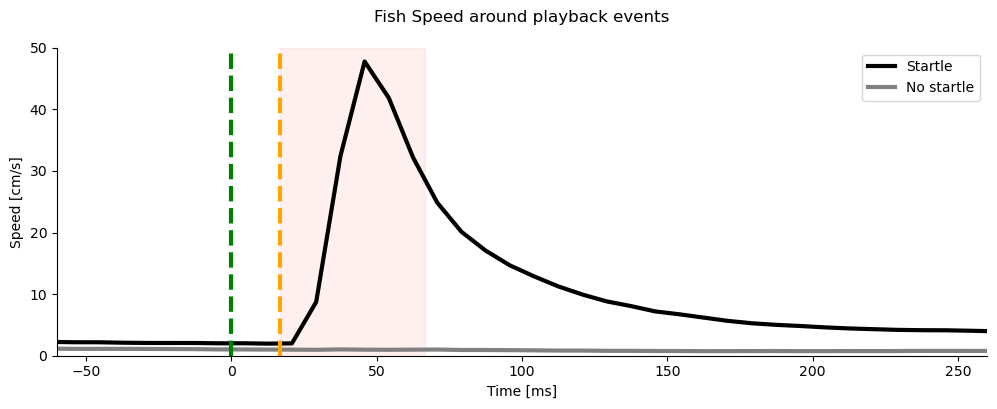

In [10]:
# Average speed, startles vs. non-startles
fig,ax = plt.subplots(figsize=(12,4))
ax.plot(1e3*tv,np.nanmean(v[startle],axis=0), c='k', lw=3, label='Startle')
ax.plot(1e3*tv,np.nanmean(v[~startle],axis=0), c='gray', lw=3, label='No startle')
plt.axvline(0,ls='--',c='g',lw=3)
plt.axvspan(1e3*((f1-f0)/frate),1e3*((f2-f0)/frate),color='red',alpha=.06)
plt.axvline(1e3*((f1-f0)/frate),ls='--',lw=3,c='orange')
ax.set_ylabel("Speed [cm/s]"), ax.set_xlabel("Time [ms]"), ax.set_xlim([-60,260]), ax.set_ylim([0,50])
ax.spines[['top','right']].set_visible(False), ax.set_title("Fish Speed around playback events\n"), ax.legend(loc="upper right")

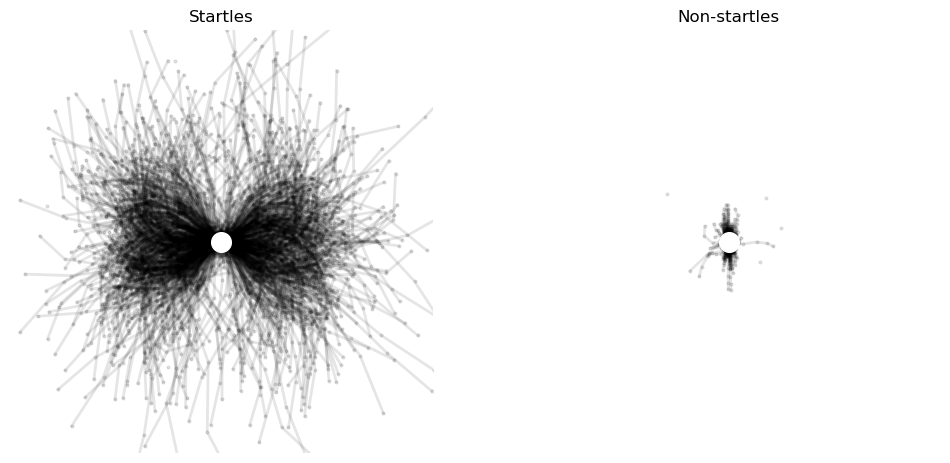

In [11]:
# Centered trajectories, startles vs. non-startles
fig, ax = plt.subplots(1,2, figsize=(12,6))
x_cT = x.T - x.T[f1]
y_cT = y.T - y.T[f1]
ax[0].plot(x_cT[f1:f2+1,startle],y_cT[f1:f2+1,startle],'-o', markersize=2, color='k', alpha=0.1, lw=2), ax_format(ax[0]), ax[0].set_title("Startles")
ax[1].plot(x_cT[f1:f2+1,~startle],y_cT[f1:f2+1,~startle],'-o', markersize=2, color='k', alpha=0.1, lw=2), ax_format(ax[1]), ax[1].set_title("Non-startles")
ax[0].scatter(0,0,s=200,c="white",zorder=10)
ax[1].scatter(0,0,s=200,c="white",zorder=10)

### Fig 3B | Directional bias heatmaps

In [12]:
displace = x[:,f2]-x[:,f1]
idxnan = np.isnan(displace)
toright = (displace > 0).astype(float)
toright[idxnan] = np.nan # where the direction could not be determined
toright[~df1['startle']] = np.nan # avoid saving direction for non-reaction events
df1['toright'] = toright

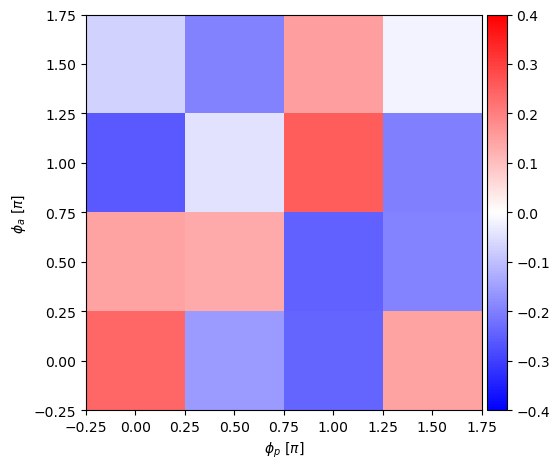

In [13]:
fig, ax = plt.subplots()
edg = [-0.25,0.25,0.75,1.25,1.75]
isnan = np.isnan(df1['toright'].values)
bin_means, xbin_edges, ybin_edges, binnumber = scipy.stats.binned_statistic_2d(x=(df1['a-phase'].values)[~isnan], y=df1['p-phase'].values[~isnan], values=df1['toright'].values[~isnan], bins = [edg,edg],statistic='mean', expand_binnumbers=False)
im = ax.imshow(bin_means-0.5, extent = (-0.25,1.75,-0.25,1.75),aspect='equal', origin='lower', vmin=-0.4, vmax=0.4, cmap='bwr')
ax.set_xlabel(r"$\phi_{p}~[\pi]$"), ax.set_ylabel(r"$\phi_{a}~[\pi]$")
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')
fig.tight_layout()

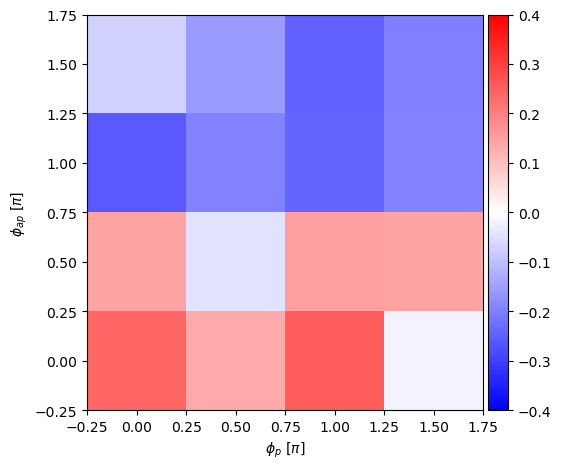

In [14]:
fig, ax = plt.subplots()
edg = [-0.25,0.25,0.75,1.25,1.75]
isnan = np.isnan(df1['toright'].values)
bin_means, xbin_edges, ybin_edges, binnumber = scipy.stats.binned_statistic_2d(x=(df1['ap-phase_mod2'].values)[~isnan], y=df1['p-phase'].values[~isnan], values=df1['toright'].values[~isnan], bins = [edg,edg],statistic='mean', expand_binnumbers=False)
im = ax.imshow(bin_means-0.5, extent = (-0.25,1.75,-0.25,1.75),aspect='equal', origin='lower',vmin=-0.4,vmax=0.4,cmap='bwr')
ax.set_xlabel(r"$\phi_{p}~[\pi]$"),ax.set_ylabel(r"$\phi_{ap}~[\pi]$")
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')
fig.tight_layout()

### Fig 3C | Centered trajectories

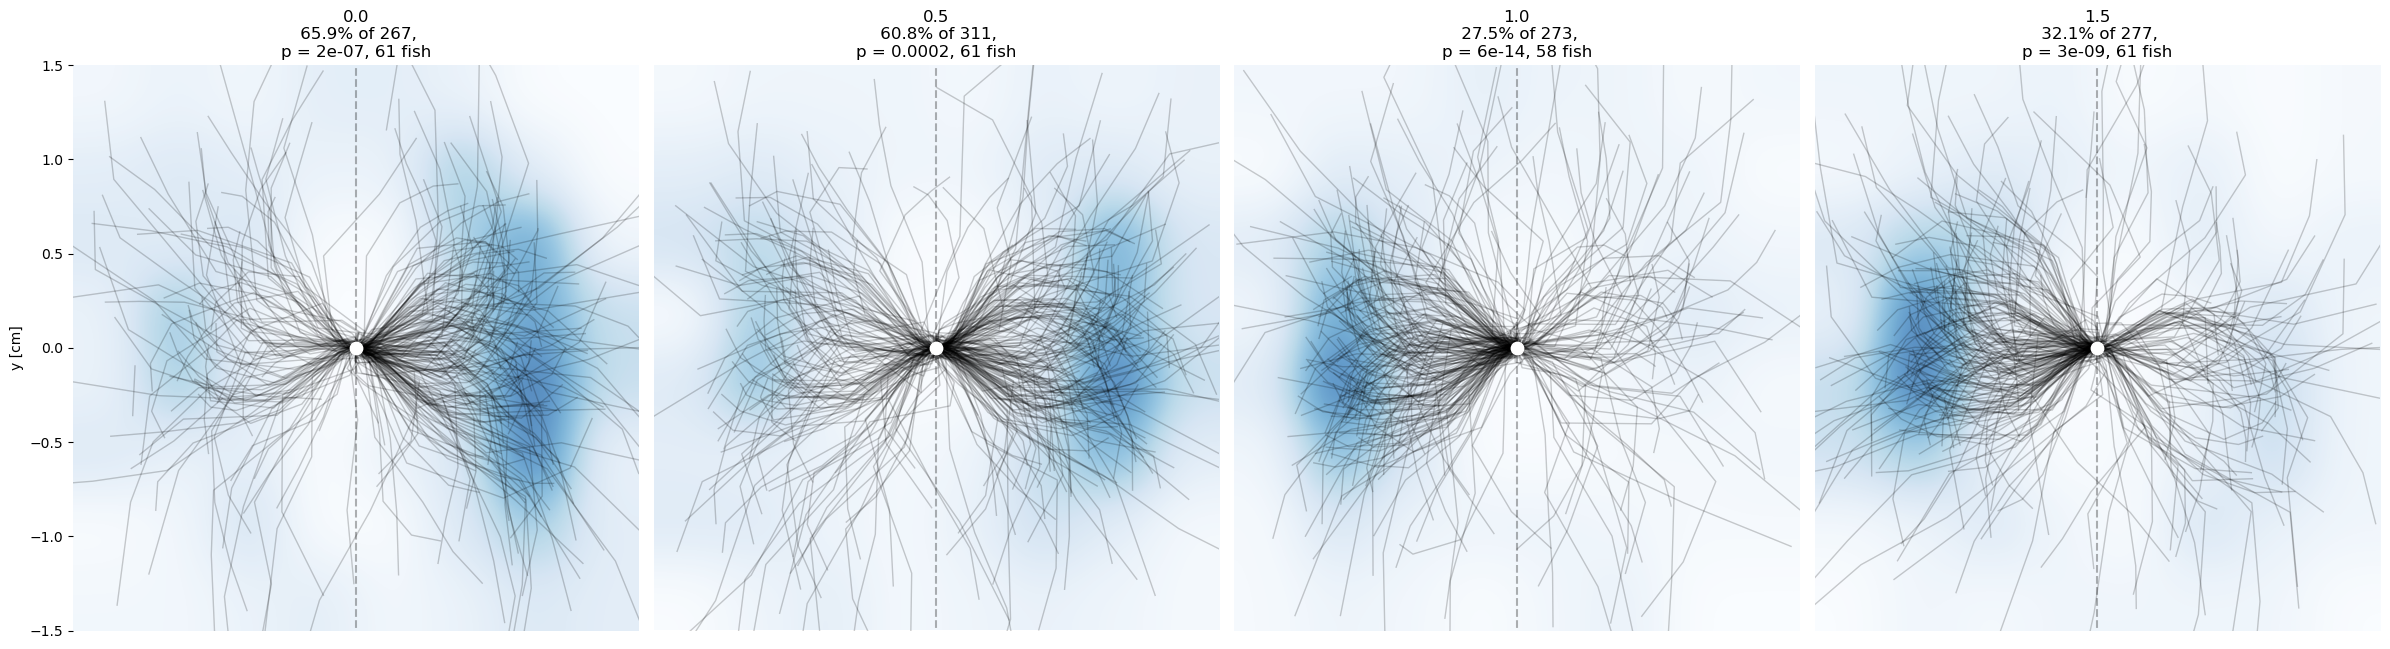

In [15]:
groupby = 'ap-phase_mod2'
groups = sorted(np.unique(df1[groupby]))
fig, ax = plot_trajectories(df1, groupby, groups, f1, f2, frate=frate)

### Fig 3D | Individual Directional Bias

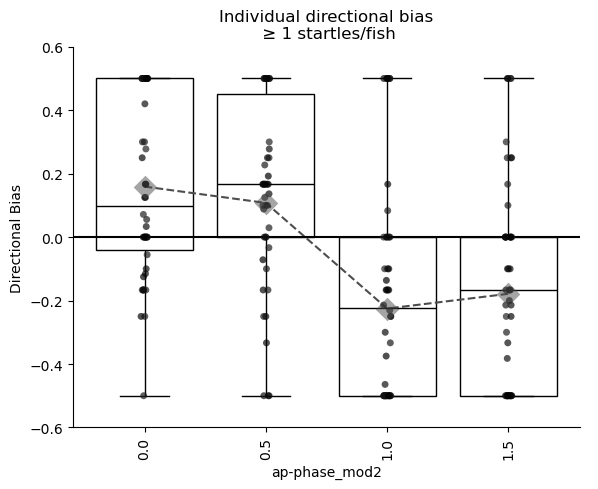

In [16]:
groupby = "ap-phase_mod2"
fig, ax = plot_individual_dirbias(df1, groupby)

## Figure 3E-G

### Data

In [17]:
#!wget https://gin.g-node.org/danionella/Veith_et_al_2024/raw/6befcd4b4c0cd7434b6b2fa9595dd80599451366/behavior/74fish_lla.zip -O 74fish_withlla.zip
fn = "../../preprocessed_data_gnode_upload/1Dphases_amps.zip"
df2 = pd.read_pickle(fn)

### Startle classification

In [18]:
# Core analysis & grouping over stimuli
x = np.stack(df2["s7_x_cm"].values)
y = np.stack(df2["s7_y_cm"].values)
v = np.stack(df2["s7_v_cmps"].values)
t = (np.arange(x.shape[1]) - f0)/frate
tv = t[:-1] + 0.5 / frate

startle = np.nanmean(abs(v[:,thr_f0:thr_f1]),axis=1) > v_thr
df2['startle'] = startle
print(f"{np.sum(startle)} startle(s) detected.")

701 startle(s) detected.


/tmp/ipykernel_1822121/336325018.py:8: RuntimeWarning: Mean of empty slice
  startle = np.nanmean(abs(v[:,thr_f0:thr_f1]),axis=1) > v_thr


(None,
 Text(0.5, 1.0, 'Fish Speed around playback events\n'),
 <matplotlib.legend.Legend at 0x7f0b8c887830>)

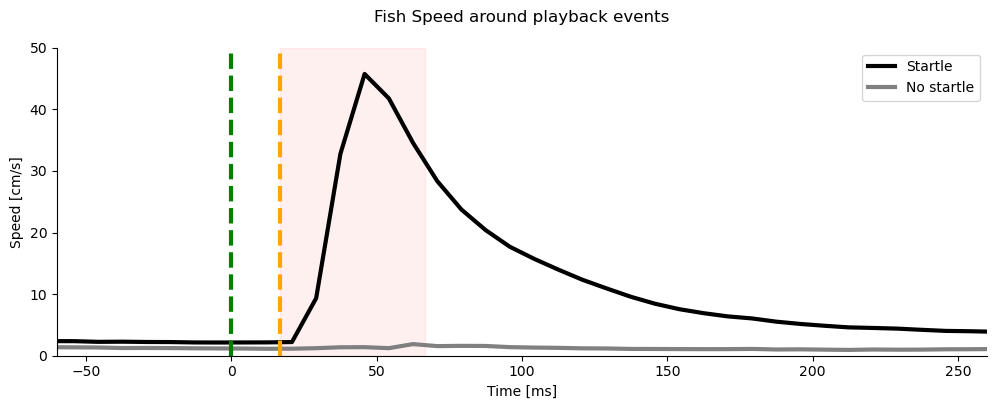

In [19]:
# Average speed, startles vs. non-startles
fig,ax = plt.subplots(figsize=(12,4))
ax.plot(1e3*tv,np.nanmean(v[startle],axis=0), c='k', lw=3, label='Startle')
ax.plot(1e3*tv,np.nanmean(v[~startle],axis=0), c='gray', lw=3, label='No startle')
plt.axvline(0,ls='--',c='g',lw=3)
plt.axvspan(1e3*((f1-f0)/frate),1e3*((f2-f0)/frate),color='red',alpha=.06)
plt.axvline(1e3*((f1-f0)/frate),ls='--',lw=3,c='orange')
ax.set_ylabel("Speed [cm/s]"), ax.set_xlabel("Time [ms]"), ax.set_xlim([-60,260]), ax.set_ylim([0,50])
ax.spines[['top','right']].set_visible(False), ax.set_title("Fish Speed around playback events\n"), ax.legend(loc="upper right")

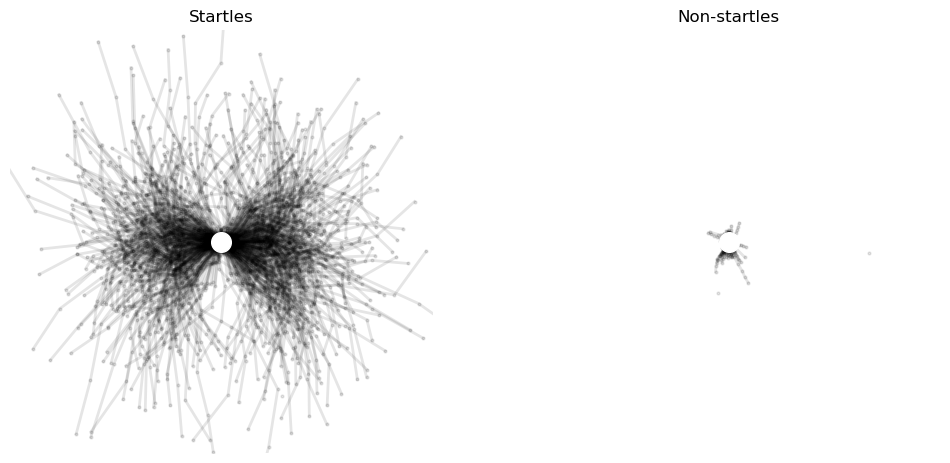

In [20]:
# Centered trajectories, startles vs. non-startles
fig, ax = plt.subplots(1,2, figsize=(12,6))
x_cT = x.T - x.T[f1]
y_cT = y.T - y.T[f1]
ax[0].plot(x_cT[f1:f2+1,startle],y_cT[f1:f2+1,startle],'-o', markersize=2, color='k', alpha=0.1, lw=2), ax_format(ax[0]), ax[0].set_title("Startles")
ax[1].plot(x_cT[f1:f2+1,~startle],y_cT[f1:f2+1,~startle],'-o', markersize=2, color='k', alpha=0.1, lw=2), ax_format(ax[1]), ax[1].set_title("Non-startles")
ax[0].scatter(0,0,s=200,c="white",zorder=10)
ax[1].scatter(0,0,s=200,c="white",zorder=10)

### Fig 3E | Directional bias heatmaps

In [21]:
displace = x[:,f2]-x[:,f1]
idxnan = np.isnan(displace)
toright = (displace > 0).astype(float)
toright[idxnan] = np.nan # where the direction could not be determined
toright[~df2['startle']] = np.nan # avoid saving direction for non-reaction events
df2['toright'] = toright

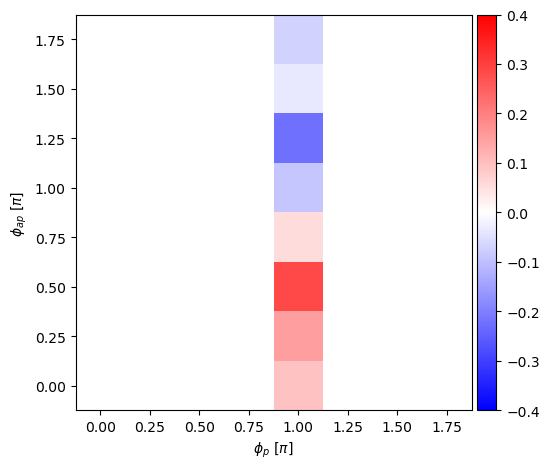

In [22]:
fig, ax = plt.subplots()
edg = [-0.125,  0.125,  0.375,  0.625,  0.875,  1.125,  1.375,  1.625, 1.875]
isnan = np.isnan(df2['toright'].values)
bin_means, xbin_edges, ybin_edges, binnumber = scipy.stats.binned_statistic_2d(x=(df2['ap-phase_mod2'].values)[~isnan], y=df2['p-phase'].values[~isnan], values=df2['toright'].values[~isnan], bins = [edg,edg],statistic='mean', expand_binnumbers=False)
im = ax.imshow(bin_means-0.5, extent = (-0.125,1.875,-0.125,1.875),aspect='equal', origin='lower',vmin=-0.4,vmax=0.4,cmap='bwr')
ax.set_xlabel(r"$\phi_{p}~[\pi]$"),ax.set_ylabel(r"$\phi_{ap}~[\pi]$")
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')
fig.tight_layout()

### Fig 3F | Individual Directional Bias

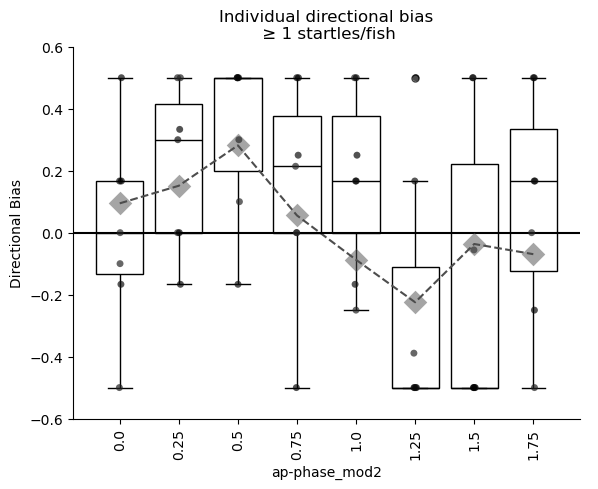

In [23]:
groupby = "ap-phase_mod2"
fig, ax = plot_individual_dirbias(df2, groupby)

### Fig 3G | Initial model

#### Pool average directional bias for experiment 1 & 2

In [24]:
# Average directional bias experiment 1
groupby = "ap-phase_mod2"
df1_sub = df1[df1["p-phase"] == 1.0] # select subset of experiment 1 in which pressure phase matches the fixed phase in experiment 2
tmp_mean = df1_sub[~np.isnan(df1_sub['toright'].values)].groupby([groupby])['toright'].agg(['mean', 'sum', 'std'])
tmp_mean.reset_index(inplace=True)
tmp_mean['mean'] -= .5
phases1 = tmp_mean[groupby].values
data1 = tmp_mean['mean'].values

# Average directional bias experiment 2
tmp_mean = df2[~np.isnan(df2['toright'].values)].groupby([groupby])['toright'].agg(['mean', 'sum', 'std'])
tmp_mean.reset_index(inplace=True)
tmp_mean['mean'] -= .5
phases2 = tmp_mean[groupby].values
data2 = tmp_mean['mean'].values

#### Initial model: analytical solution to time-averaged acoustic intensity for cosine waveforms

In [25]:
a_p_phases = np.linspace(0,1.75*np.pi,1000)
cosine_model = np.sin(a_p_phases) # derived analytically, see Supplemental material

#### Initial model: numerical solution to time-averaged acoustic intensity for gammatone waveforms

In [26]:
def gammatone(b, f, phi, n, duration, padduration, sr):
    t = np.arange(int(duration * sr)) / sr
    gammat = t ** (n - 1) * np.exp(-2 * np.pi * b * t) * np.cos(2 * np.pi * f * t + phi)
    gammat = np.pad(gammat, int(padduration * sr))
    gammat /= np.max(abs(gammat))
    return gammat, locals()
    
p_amp = 223.87
a_amp = 7.54
phi_p = np.pi
phis_a= phases2 * np.pi

gammatone_model = []
for phi_a in phis_a:
    wav_a, params_a = gammatone(b=120, f=800, phi=phi_a, n=2, duration=0.012, padduration=0.0013, sr=51200)
    wav_p, params_p = gammatone(b=120, f=800, phi=phi_p, n=2, duration=0.012, padduration=0.0013, sr=51200)
    wav_a *= a_amp
    wav_p *= p_amp
    wav_v = np.cumsum(wav_a)/51200
    gammatone_model.append(np.mean(wav_v*wav_p))

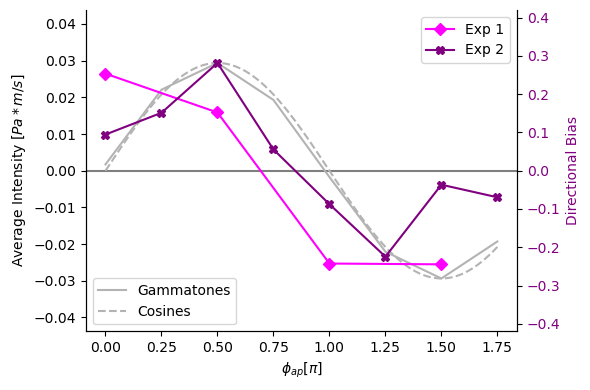

In [27]:
fig,ax = plt.subplots(figsize=(6,4))

# Numerical solution for actual target waveforms
ax.axhline(0,c='k',alpha=.5)
ax.plot(np.roll(((phis_a-phi_p)/np.pi)%2,4),np.roll(gammatone_model,4),c='.7',label="Gammatones")

# Analytical solution for simplified waveforms
scale = np.max(abs(np.array(gammatone_model)))
ax.plot(a_p_phases/np.pi,scale*cosine_model,ls="--",c='.7',label="Cosines")

# Data
ax2 = ax.twinx()
ax2.plot(phases1, data1, label = "Exp 1", color='fuchsia', marker = 'D')
ax2.plot(phases2, data2, label = "Exp 2", color='purple', marker = 'X')

ax.set_xlabel(r"$\phi_{ap} [\pi]$")
ax.set_ylabel(r'Average Intensity $[Pa * m/s]$', color='k'),ax2.set_ylabel('Directional Bias', color='purple')
ax2.tick_params(axis='y', labelcolor='purple')
ylim = .42*scale/np.max((abs(data2)))
ax.set_ylim([-ylim,ylim]), ax2.set_ylim([-.42,.42])
ax.spines['top'].set_visible(False), ax2.spines['top'].set_visible(False)
ax.legend(loc='lower left'),ax2.legend(loc='upper right')
fig.tight_layout()

## Figure 4B-F

### Data

In [28]:
#!wget https://gin.g-node.org/danionella/Veith_et_al_2024/raw/6befcd4b4c0cd7434b6b2fa9595dd80599451366/behavior/74fish_lla.zip -O 74fish_withlla.zip
fn = "../../preprocessed_data_gnode_upload/1Dphases_freqs.zip"
df3 = pd.read_pickle(fn)

### Startle classification

In [29]:
# Core analysis & grouping over stimuli
x = np.stack(df3["s7_x_cm"].values)
y = np.stack(df3["s7_y_cm"].values)
v = np.stack(df3["s7_v_cmps"].values)
t = (np.arange(x.shape[1]) - f0)/frate
tv = t[:-1] + 0.5 / frate

startle = np.nanmean(abs(v[:,thr_f0:thr_f1]),axis=1) > v_thr
df3['startle'] = startle
print(f"{np.sum(startle)} startle(s) detected.")

3484 startle(s) detected.


/tmp/ipykernel_1822121/4039869504.py:8: RuntimeWarning: Mean of empty slice
  startle = np.nanmean(abs(v[:,thr_f0:thr_f1]),axis=1) > v_thr


(None,
 Text(0.5, 1.0, 'Fish Speed around playback events\n'),
 <matplotlib.legend.Legend at 0x7f0b8d1c0c20>)

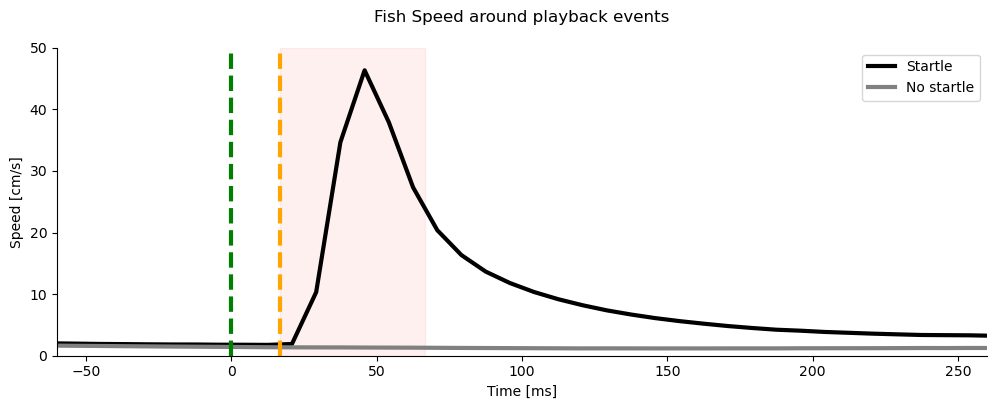

In [30]:
# Average speed, startles vs. non-startles
fig,ax = plt.subplots(figsize=(12,4))
ax.plot(1e3*tv,np.nanmean(v[startle],axis=0), c='k', lw=3, label='Startle')
ax.plot(1e3*tv,np.nanmean(v[~startle],axis=0), c='gray', lw=3, label='No startle')
plt.axvline(0,ls='--',c='g',lw=3)
plt.axvspan(1e3*((f1-f0)/frate),1e3*((f2-f0)/frate),color='red',alpha=.06)
plt.axvline(1e3*((f1-f0)/frate),ls='--',lw=3,c='orange')
ax.set_ylabel("Speed [cm/s]"), ax.set_xlabel("Time [ms]"), ax.set_xlim([-60,260]), ax.set_ylim([0,50])
ax.spines[['top','right']].set_visible(False), ax.set_title("Fish Speed around playback events\n"), ax.legend(loc="upper right")

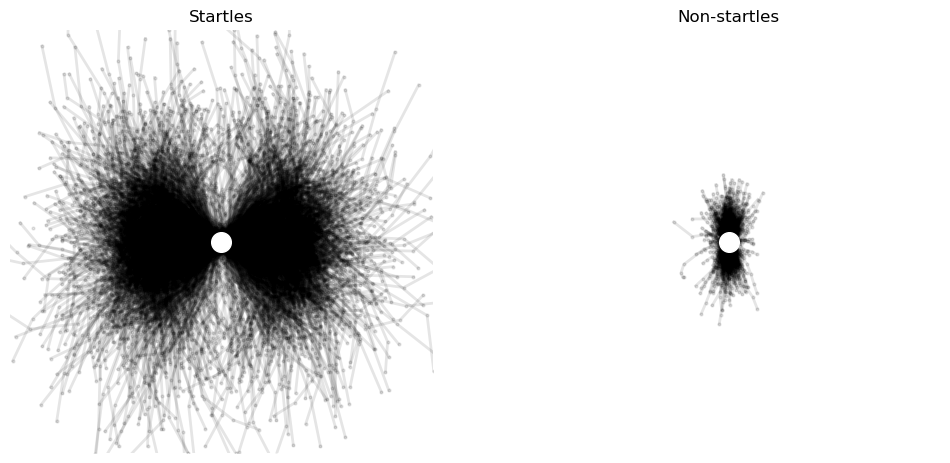

In [31]:
# Centered trajectories, startles vs. non-startles
fig, ax = plt.subplots(1,2, figsize=(12,6))
x_cT = x.T - x.T[f1]
y_cT = y.T - y.T[f1]
ax[0].plot(x_cT[f1:f2+1,startle],y_cT[f1:f2+1,startle],'-o', markersize=2, color='k', alpha=0.1, lw=2), ax_format(ax[0]), ax[0].set_title("Startles")
ax[1].plot(x_cT[f1:f2+1,~startle],y_cT[f1:f2+1,~startle],'-o', markersize=2, color='k', alpha=0.1, lw=2), ax_format(ax[1]), ax[1].set_title("Non-startles")
ax[0].scatter(0,0,s=200,c="white",zorder=10)
ax[1].scatter(0,0,s=200,c="white",zorder=10)

### Fig 4B | Exploring the effect of the phase-delay and time-delay parameters on model

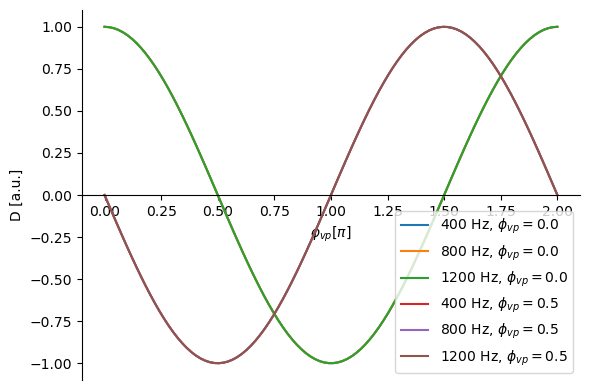

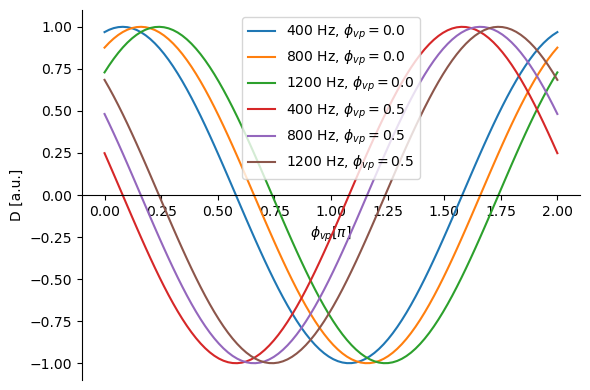

In [32]:
taus = [0,-.1e-3]
phi_phaseshift_vps = [0,0.5*np.pi]
phis = np.linspace(0,2*np.pi,100)[:]
fs = np.array([400,800,1200])

for tau in taus:
    plt.figure(figsize=(6,4))
    for phi_phaseshift_vp in phi_phaseshift_vps:
        for i,f in enumerate(fs):
            phitaufish = 2*np.pi*f*tau
            plt.plot(phis/np.pi,np.cos(phis + phi_phaseshift_vp + phitaufish), label = f"{f} Hz, " + r"$\phi_{vp} = $" + f"{phi_phaseshift_vp/np.pi}")
    plt.legend()
    plt.xlabel(r"$\phi_{vp} [\pi]$"),plt.ylabel(r"D [a.u.]")
    plt.gca().spines['top'].set_visible(False),plt.gca().spines['right'].set_visible(False),plt.gca().spines['bottom'].set_position('zero')
    plt.tight_layout()

### Fig 4C | Exploring the effect of the phase-delay and time-delay parameters on model

In [33]:
displace = x[:,f2]-x[:,f1]
idxnan = np.isnan(displace)
toright = (displace > 0).astype(float)
toright[idxnan] = np.nan # where the direction could not be determined
toright[~df3['startle']] = np.nan # avoid saving direction for non-reaction events
df3['toright'] = toright

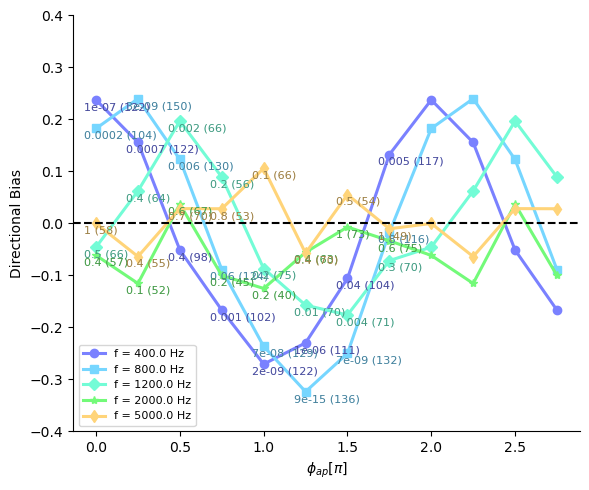

In [34]:
fig, ax = plot_tc_by_freq(df3,annotate_ps = True)

### Fig 4D | Model fit

Fit: -0.0002720571*2π*f + 0.1949566π


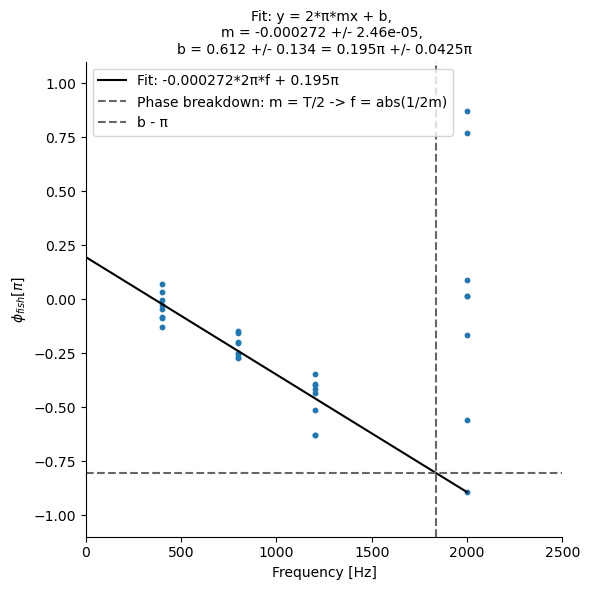

In [35]:
fig, ax = tc_fit(df3)

### Fig 4E | Fitted model

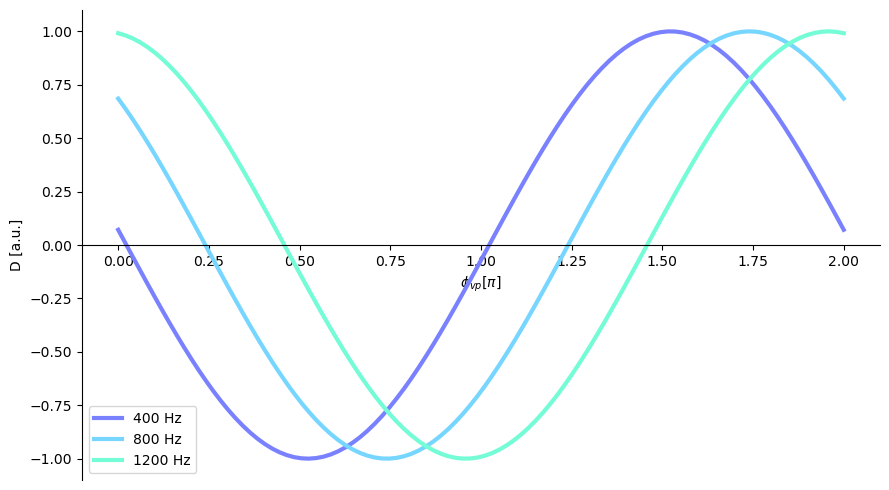

In [36]:
tau = -0.2720571e-3
phi_phaseshift_ap =0.1949566*np.pi
phi_phaseshift_vp = phi_phaseshift_ap + np.pi/2 # as phi_vp = phi_ap - pi/2, the tuning has to compensate this shift

plt.figure(figsize=(9,5))
phis = np.linspace(0,2*np.pi,100)[:]
fs = np.array([400,800,1200])
cls = [(122/255,129/255,255/255),(118/255,214/255,255/255),(115/255,252/255,214/255)]
for i,f in enumerate(fs):
    phitaufish = 2*np.pi*f*tau
    plt.plot(phis/np.pi,np.cos(phis + phi_phaseshift_vp + phitaufish), c=cls[i],label = f"{f} Hz",lw=3)
plt.legend()
plt.xlabel(r"$\phi_{vp} [\pi]$"),plt.ylabel(r"D [a.u.]")
plt.gca().spines['top'].set_visible(False),plt.gca().spines['right'].set_visible(False),plt.gca().spines['bottom'].set_position('zero')
plt.tight_layout()

### Fig 4F | Monopole decay with distance

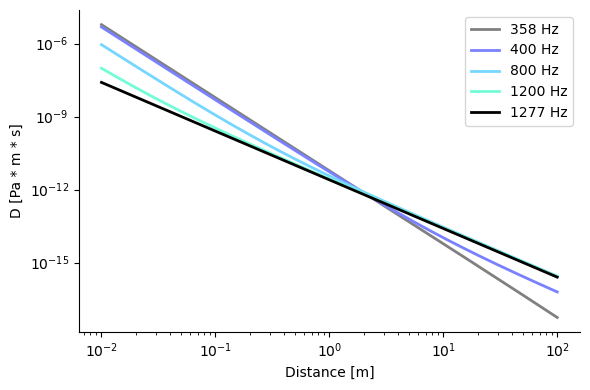

In [37]:
# Direction at distances, pd
tau = -0.2720571e-3
phi_phaseshift_ap =0.1949566*np.pi
phi_phaseshift_dp = phi_phaseshift_ap+np.pi

c = 1500
rho = 1000
p0 = 10**(147/20)*1e-6 # 147 dB in Pascal
r0 = 0.011 # 1 body length

fs = np.array([358,400,800,1200,1277])
cls = [(0.5,0.5,0.5),(122/255,129/255,255/255),(118/255,214/255,255/255),(115/255,252/255,214/255),(0,0,0)]
r = np.logspace(-2,2,1000)

plt.figure(figsize=(6,4))
for i,f in enumerate(fs): 
    w = 2*np.pi*f
    k = w/c
    A = -(p0*r0/r)**2 * 1/(2*rho*w**2)
    tuning_part1 = A*(1/r*np.cos(phi_phaseshift_dp + w*tau))
    tuning_part2 = -A*(k*np.sin(phi_phaseshift_dp + w*tau))
    tuning = tuning_part1 + tuning_part2
    plt.plot(r,tuning,label=f"{f} Hz",lw=2, c=cls[i])

plt.gca().spines['top'].set_visible(False),plt.gca().spines['right'].set_visible(False)
plt.xscale('log'), plt.yscale('log')
plt.gca().set_xticks([0.01,0.1,1,10, 100])
plt.gca().set_yticks([1e-6,1e-9,1e-12,1e-15])
plt.xlabel("Distance [m]"),plt.ylabel("D [Pa * m * s]")
plt.legend()
plt.tight_layout()